# Galactic Rotation Analysis
#### Kate Nickoriuk,  University of Toronto

A rotation curve shows the orbital rotation speed of an object at various radii from its center of orbit. The planets in our solar system obey a rotation curve defined by the proportionality $v\propto R^{-1/2}$, and it was originally expected that this would also apply to our galaxy's rate of rotation. 

Through measurements of radio signals around 1420 MHz originating from the disk of the galaxy, it is possible to calculate the speed of rotation of the Milky Way. We will find that the rotation of the galaxy increases linearly ($v \propto R$) up to a radius of about 5 kpc, then remains constant at a velocity around 185 km/s. It does not follow the same proportionality that the solar system does, and this is strong evidence of dark matter within the galactic halo. To account for this difference, the galaxy must be far more massive than we can measure.

## Packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import warnings
warnings.simplefilter('ignore', np.RankWarning)

import data_functions
import plot_functions
plot_functions.set_plot_style()

Some variables: the frequency of the 21-cm line, the distance from the sun to the Milky Way core, velocity of the sun through the galaxy, and a list of longitudes (ordered in such a way that matches the data).

In [4]:
f21cm = 1420.405 #MHz
R_sun = 8 #kpc
v_sun = 220 #km/s
longitudes = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 
                  65, 70, 75, 80, 85, 90, 95, 100, 110, 130, 
                  140, 150, 160, 170, 180, 190, 120]

## Some Background

### Rotation Curves
A <mark>rotation curve</mark> is a visual representation of the relationship of orbital velocity and distance to the center of orbit. A solid body has a linear relationship, $v\propto R$. For separate orbiting entities, we have seen that it follows a relationship of $v\propto R^{-1/2}$. In our solar system, all of the planets follow this relationship. This is known as the <mark>**Keplerian rotation curve**</mark>, since it follows from Johannes Kepler's laws. 

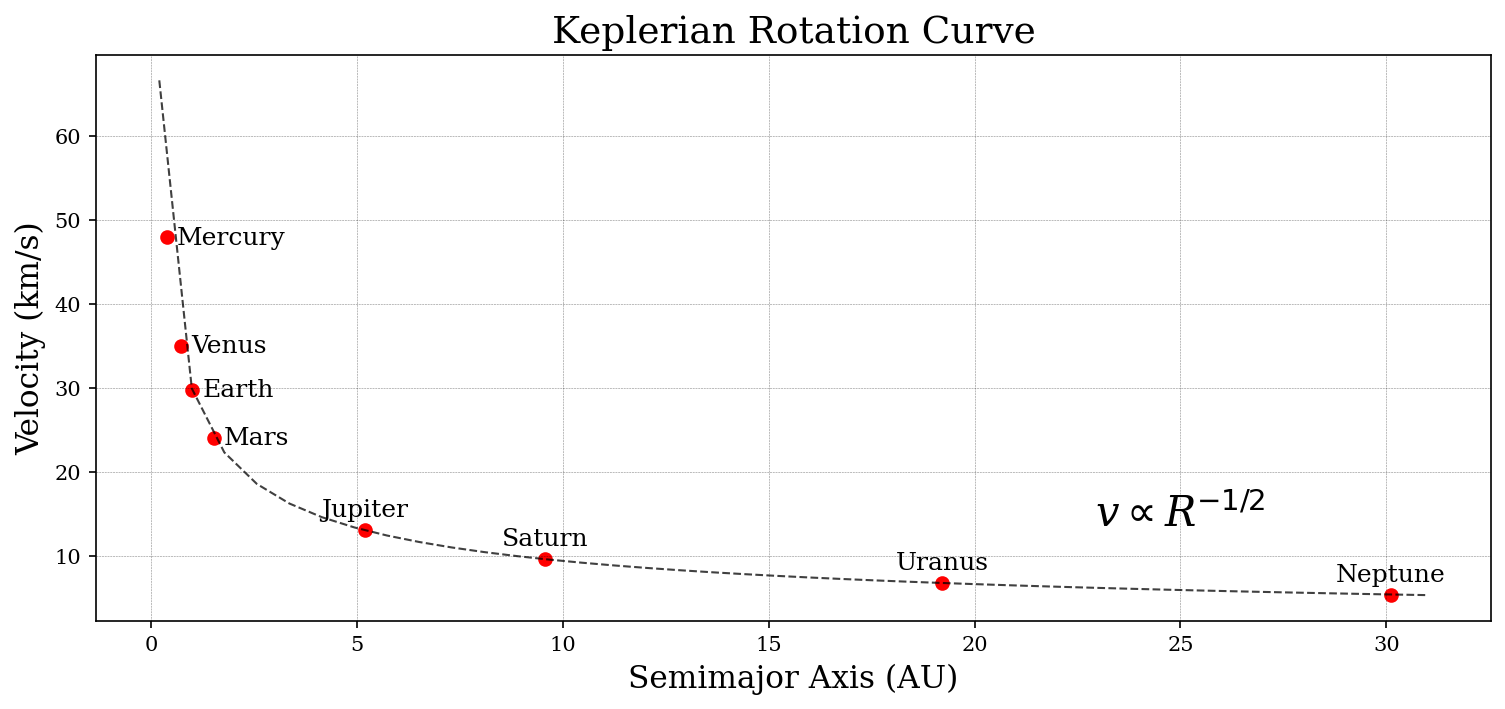

In [5]:
plot_functions.plot_keplerian_curve();

When considering the Milky Way, astronomers expected its rotation curve outside of the solid-body core to be similarly shaped to the Keplerian Curve, since they could determine the approximate distribution of stars based on visible light. However this was found not to be the case. In measuring the red-shifted radio signals from the galaxy, it is possible to construct the galaxy's actual rotation curve. 

### The 21-cm Hydrogen Line

The <mark>21-cm Hydrogren line</mark> is a radiowave emission from Hydrogen at a known frequency, exactly $1420.405751$ MHz. This value is ingrained in the rules of quantum-mechanics. The radiation is released when Hydrogen transitions between the two levels of its ground state. The difference between these states is defined by the direction of the electron spin; the higher ground state has an upward spin, while the lower state has a downward spin. Observing this emission implies that the Hydrogen atom made a transition from the higher level to the lower level within the ground state. This is extremely unlikely to occur, probability-wise. However since there is so much Hydrogen present in the structures of the Milky Way, these emissions can be detected.

By observing radio frequencies in the $1420$ MHz region throughout the galactic plane, we can measure how much this line has shifted in frequency due to the motion of the source we are observing. From this, the rotation curve of the galaxy can be determined using the relationship for doppler shift. 

### Doppler Shift

<mark>Doppler Shift</mark> is a phenomenon where light or sound sources that are in motion (with respect to the observer) are shifted lower or higher in frequency. The relationship between speed and amount of shift is known. This is determined through a relationship of the measured frequency $f$ and the base frequency $f_0$ (which is the frequency of the source if it was stationary with respect to the observer). In this case, $f_0 = 1420.405$ MHz.

$$ \frac{v}{c} = \frac{f_0^2-f^2}{f_0^2+f^2} \approx \frac{f_0-f}{f} $$

Here, we can make the approximation shown in the equation because we are measuring low velocities compared to the speed of light, where $v\ll c$. We can use the doppler effect to determine the relative speed of the radio source with respect to Earth. 

### Galactic Coordinates

Similar to coordinates on Earth, there are galactic coordinates to refer to a direction in the galaxy. <mark>Galactic latitude</mark> (denoted $b$) refers to the number of degrees away from the galactic plane, where a latitude of $0^\circ$ implies it is within the galactic plane. <mark>Galactic longitude</mark> (denoted $\ell$) refers to the angle along the galactic plane, where a longitude of $0^\circ$ is the direction towards the galactic core. 

![Galactic Coordinates](https://astronomy.swin.edu.au/cms/cpg15x/albums/userpics/galacticcoords.2.jpg)

Looking through the galactic plane, the line-of-sight will pass through many arms of the galaxy. Each arm in the line-of-sight will have a slightly different velocity and a different distance from the galactic core. Applying the Doppler Shift relation, this allows for the determination of how fast each arm is moving towards or away from us. With this information, we can construct the rotation curve.

## Reading In The Data

To measure radio frequencies, an AirSpy receiver is used, which is a tunable 24-1800 MHz heterodyne radio receiver. In this case it will be focused on frequencies from 1416-1426 MHz. 

In [6]:
# Reading in a single radio measurement
raw_data = data_functions.load_pickle("MP_20180328-102325.pkl")
raw_data.keys()

dict_keys(['data', 'freqs', 'times'])

The obtained data has a measurement of signal strength across the specified frequency band over some duration of time. We can take the average of the signal over time and plot the signal strength to see how it is distributed.

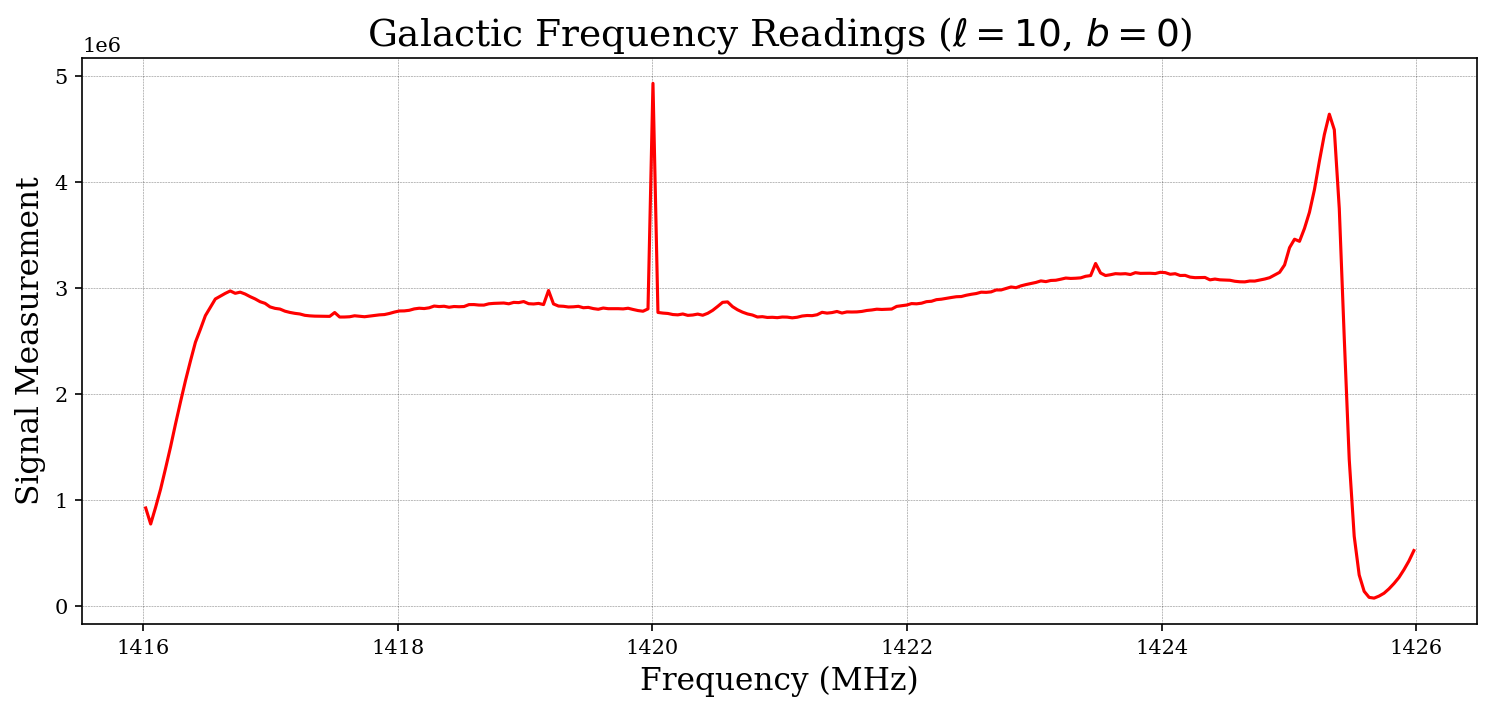

In [7]:
plot_functions.raw_data_plot(raw_data, 10, 0);

## Cleaning Up The Data

Unfortunately the AirSpy has an internally-generated signal at exactly 1420 MHz, but this signal can be omitted by dropping the datapoints within the range 1420 $\pm$ 0.01 MHz. Though this is close to the 21-cm line, it is not actually close enough to interfere with the measured data. Additionally, there are some peaks generated by <mark>**Radio Frequency Interference**</mark> (RFI) at 1419.2 MHz and 1423.5 MHz that will be dropped.

This is done with the function `get_all_datasets()`, which builds a dataframe of radio measurements for each datafile and drops the systematic RFI.

In [8]:
data = data_functions.get_all_datasets()

For each longitude in `longitudes`, the dataframe `data` contains 3 columns: the `freq` column holds frequencies ranging from 1416 MHz to 1426 MHz, `data` holds the readings when observing along the galactic arms (a latitude of 0$^\circ$), and `baseline` holds readings obtained at a direction away from the galactic plane, used for determining which signals are unrelated to the galaxy's signal.

In [9]:
data[10] # The data at longitude = 10 degrees

,freq,data,baseline
0,1416.019531,9.279724e+05,9.168536e+05
1,1416.058594,7.769408e+05,7.635629e+05
2,1416.097656,9.357462e+05,9.141739e+05
3,1416.136719,1.106088e+06,1.088300e+06
4,1416.175781,1.302576e+06,1.277601e+06
...,...,...,...
251,1425.824219,2.161267e+05,2.121877e+05
252,1425.863281,2.730601e+05,2.691890e+05
253,1425.902344,3.462509e+05,3.394734e+05
254,1425.941406,4.280594e+05,4.195900e+05


Now that the RFI and the internally-generated line at $1420$ MHz has been removed, we can take a better look at the spectrum. The plot compares the distributions at a longitude of $\ell=15^\circ$, one at latitude $b=0^\circ$ and another at $b=19^\circ$. As it is, the distribution will not provide much information.

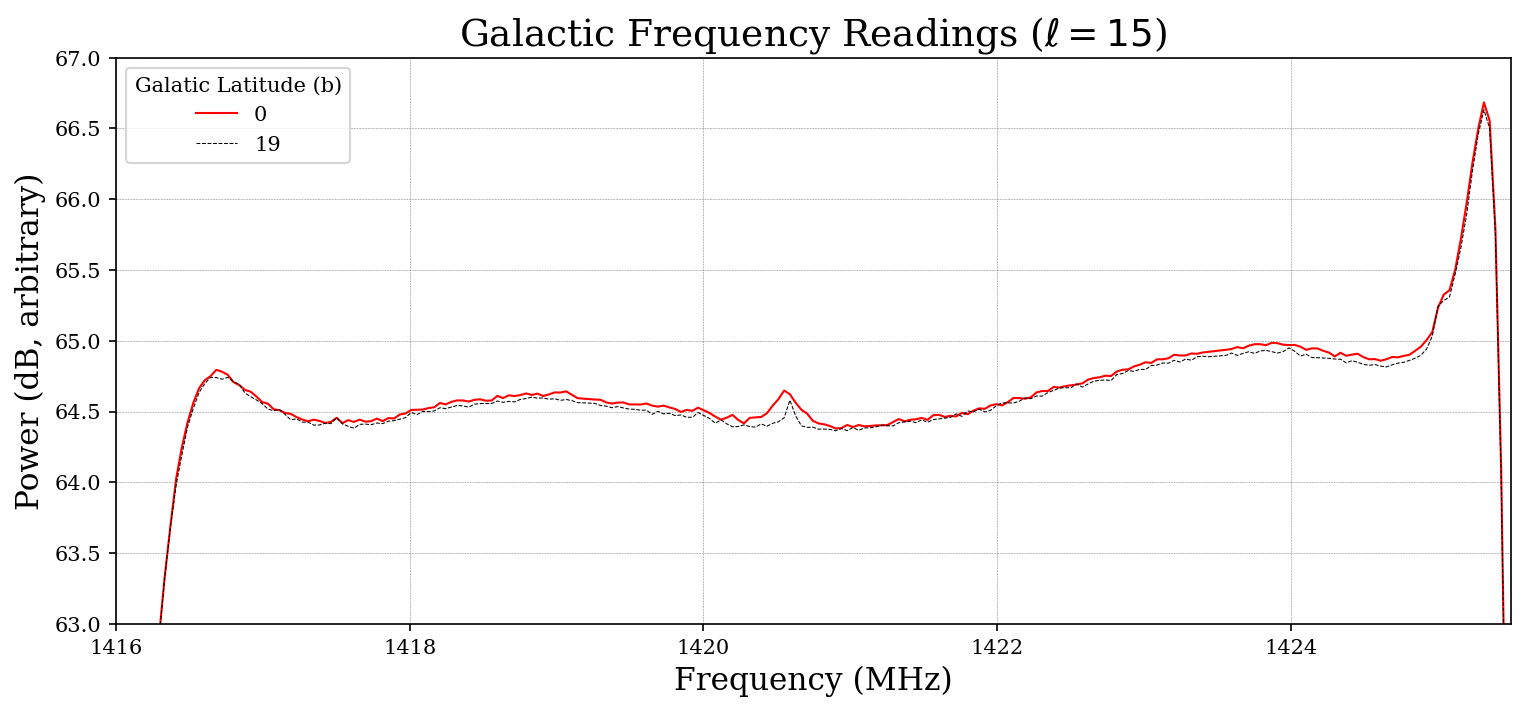

In [10]:
plot_functions.line_plot(data[15], 15, 19);

Taking the ratio of on-plane measurements to baseline measurements will allow for the visualization of differences between the two distributions. Points plotted in blue are within $0.5$ MHz of the 21-cm line. A smooth line of best fit for the points in red is added to illustrate the relationship of background radio interference.

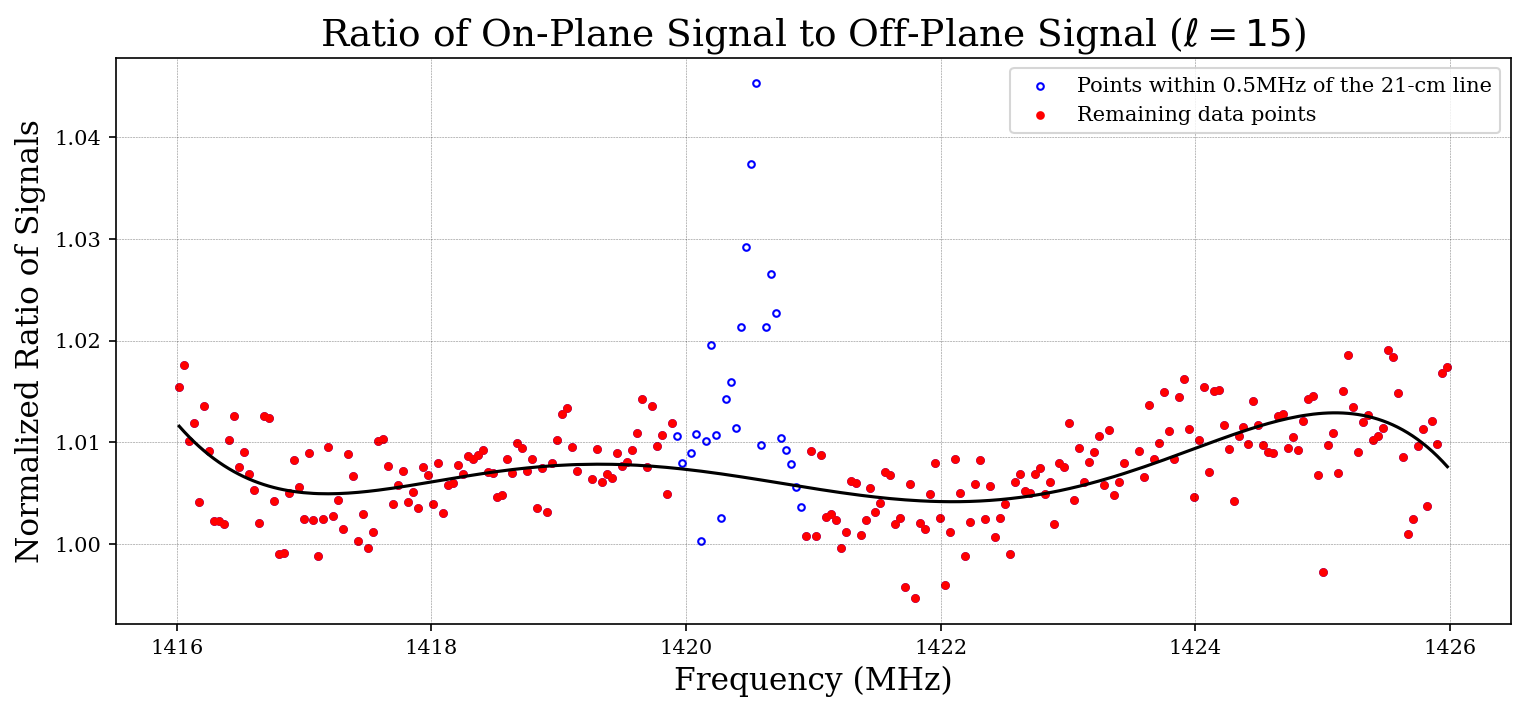

In [11]:
plot_functions.plot_baseline_fit(data[15], 15);

The data can be de-trended by subtracting the value of the line of best fit from each datapoint. The points in blue will not be included, since this is the 21-cm line peak of interest.

In [12]:
def detrend(df):
    # Obtain a dataframe only containing the points at least 0.5MHz from the 21-cm line
    df_trimmed = df.drop(df[np.abs(df.freq-f21cm) < 0.5].index)
    
    # Get the ratio of on-plane data to the baseline data
    norm_trimmed = df_trimmed.data/df_trimmed.baseline
    norm = df.data/df.baseline
    
    # Determine the relationship of background radio signals using a polynomial fit, degree 13
    fit_coeff = np.polyfit(df_trimmed.freq.tolist(), norm_trimmed.tolist(), 13)
    fit = np.polyval(fit_coeff, df.freq.tolist())
    
    # Obtain the corrected signal by subtracting the line of best fit
    return norm-fit

# For the data at longitude=15
corrected_signal = detrend(data[15])

Plotting the corrected signal with the background radio signal removed shows the strength of the 21-cm line and the various frequencies it has shifted to.

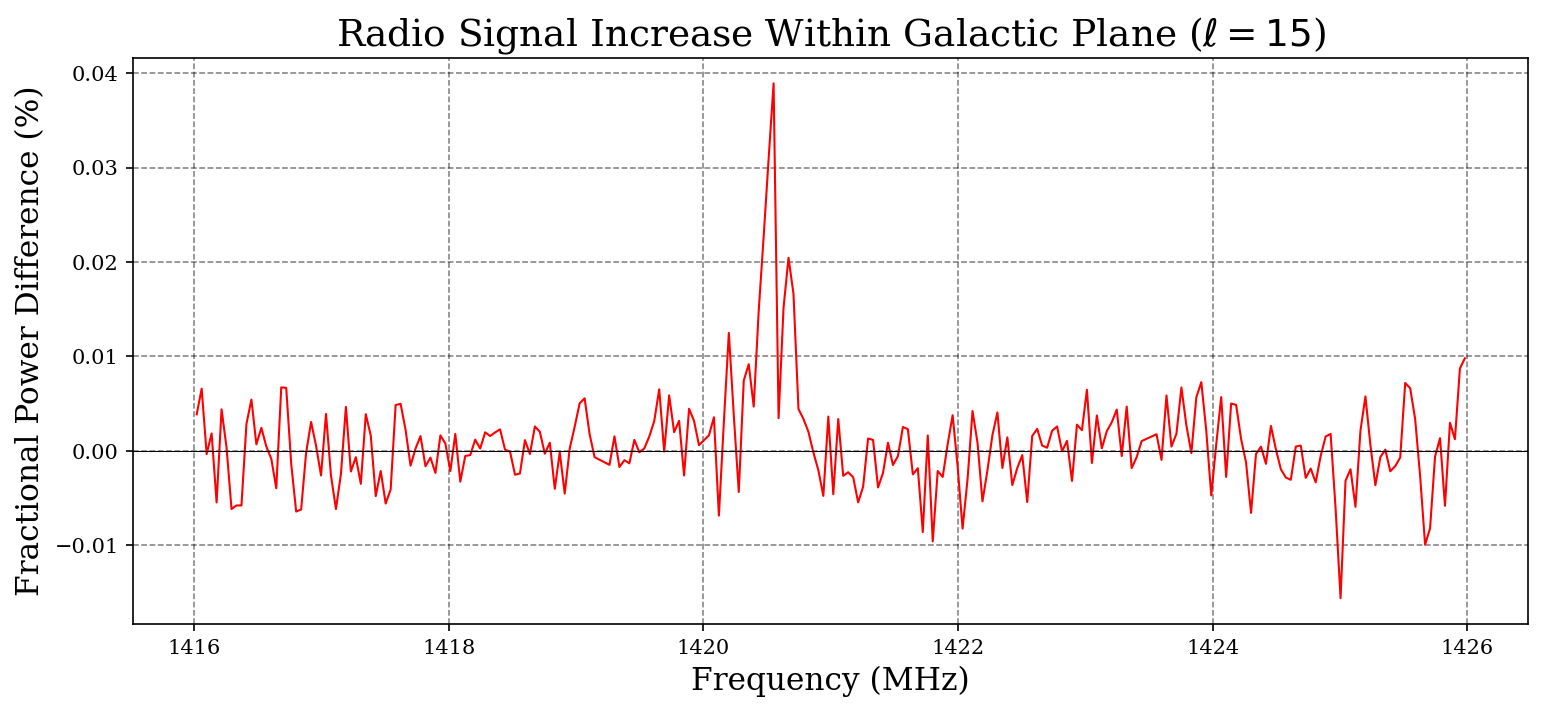

In [13]:
plot_functions.plot_detrended_freq(data[15], corrected_signal, 15);

Seen in the above plot are several peaks around the 21-cm line. Recall that each peak corresponds to a different arm of the galaxy, since they will all have different relative velocities. It is quite noisy, but the peaks in power are easily seen. This procedure can be repeated for each pair of datasets at each galactic longitude.

Since we are more interested in velocity measurements than frequency, the Doppler shift transformation will be applied to the x-axis. This then becomes a plot of velocities of the measured source with respect to us. Peaks of the noise are irrelevant, but peaks around the 21-cm line provide the radial velocity of each arm in the line-of-sight. From this data we can now begin to build the rotation curve of the Milky Way.

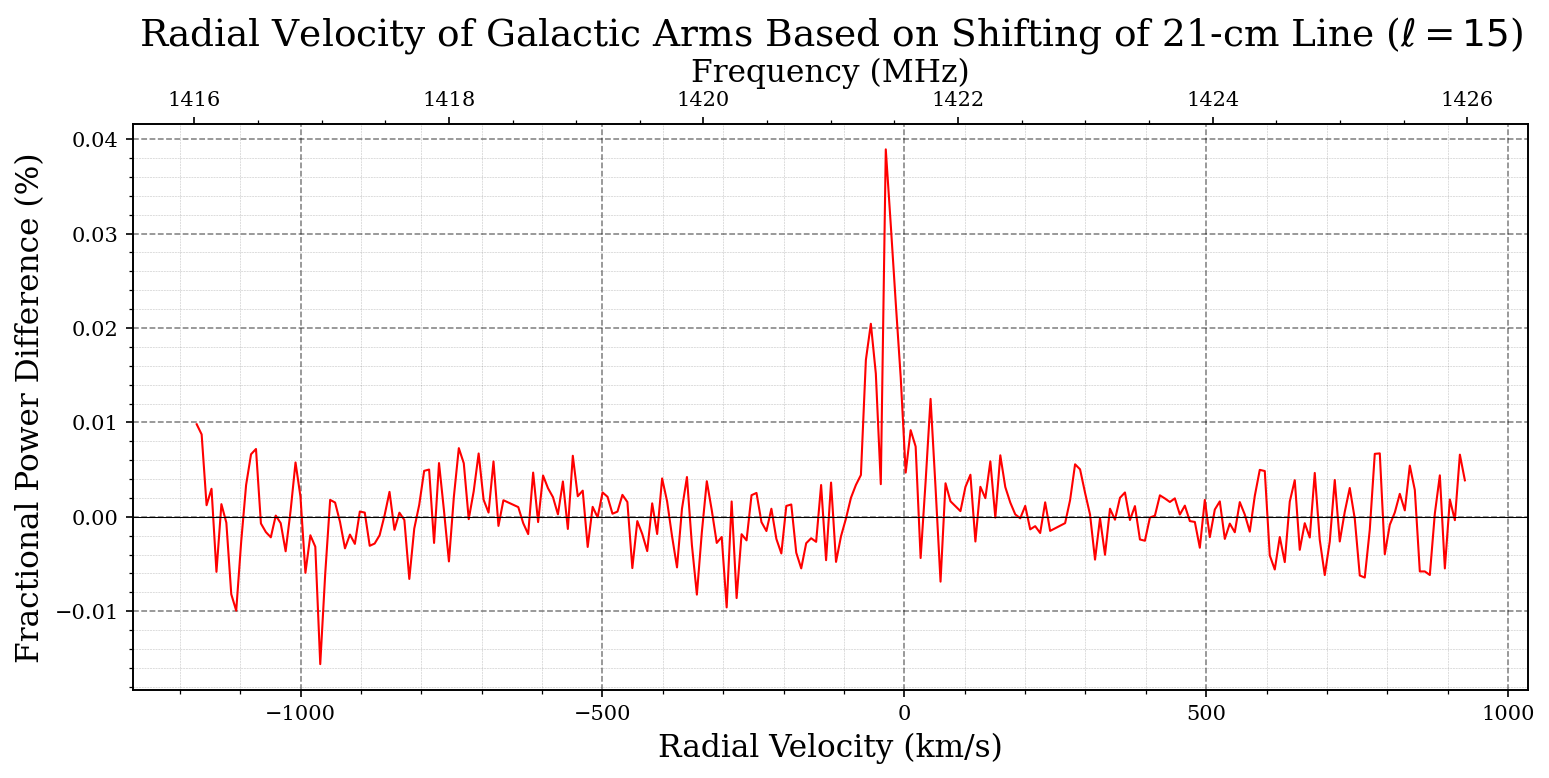

In [14]:
plot_functions.plot_normalized_signal(data[15], corrected_signal, 15);

## Building The Rotation Curve

Performing the above steps on the available data, a plot can be constructed for each longitude. This can be visualized all at once by plotting it as a heatmap. 

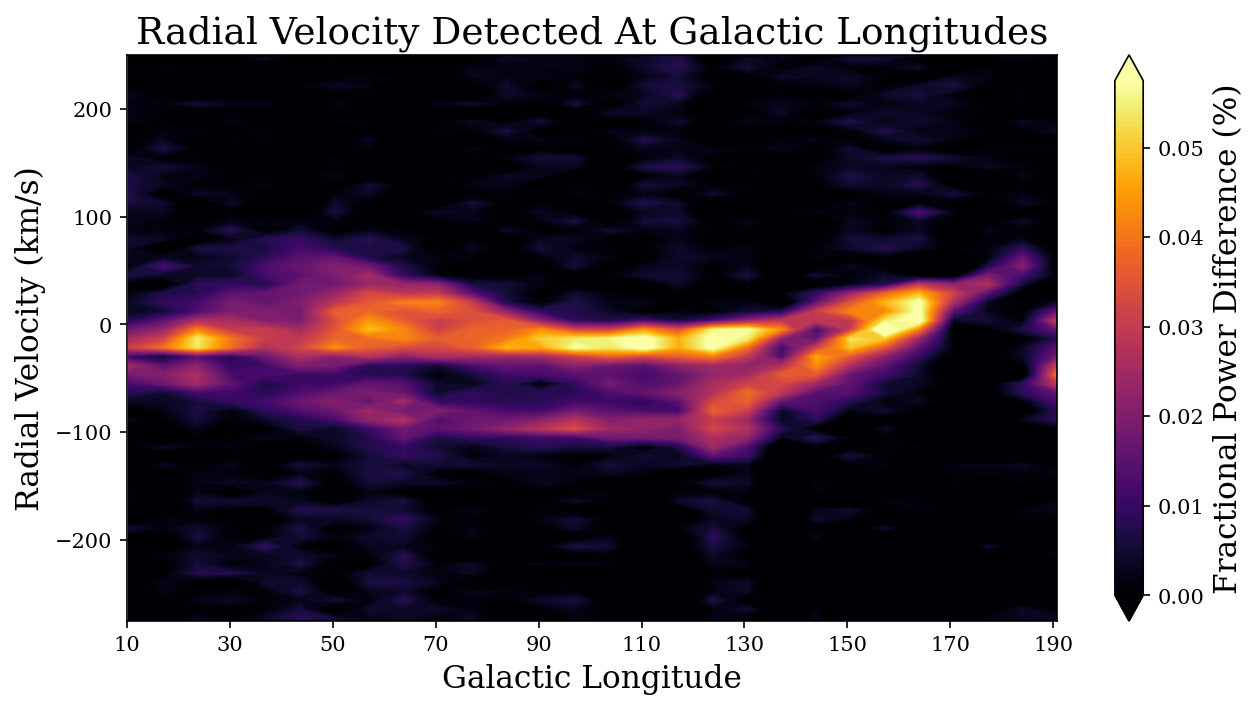

In [15]:
plot_functions.plot_rv_heatmap(data);

The brighter areas correspond to a stronger signal measured at that particular radial velocity. At different longitudes, it is evident that the radio signal peaks at different frequencies, and thus a different radial velocity would be measured. There are two primary peaks along the various galactic longitudes, which can be seen as there are two bright stripes in the plot.

To plot the rotation curve, we need to find the velocity of rotation at various distances from the galactic core. This is done using the <mark>**tangent-point method**</mark>.

The goal of this process is to find an orbital velocity $v$ for various  radii $R$ of material orbiting the galactic core. The galactic disk is broken into infinitesimally small rings that orbit the galactic core at some orbital velocity. For every longitude measurement, we can determine the radius of the ring such that the line-of-sight is tangent to this galactic disk segment. The radius of the ring is calculated with:

$$ R = R_{\text{sun}}\cdot\sin{\ell} $$ 

where $R_{\text{sun}}$ is the distance from the sun to the Milky Way core, measured to be around 8 kpc. 

Next we need the radial velocity that corresponds to the ring that was just found. Of all the radial velocities measured, we seek the one that is directed tangentially to the ring. This should be whichever radial velocity is red-shifted the most. This is because we measure the entirety of its velocity, whereas if the source is not moving directly towards or away from the observer, there will be a component of velocity that we cannot measure. 

For example, at the longitude $60^\circ$:

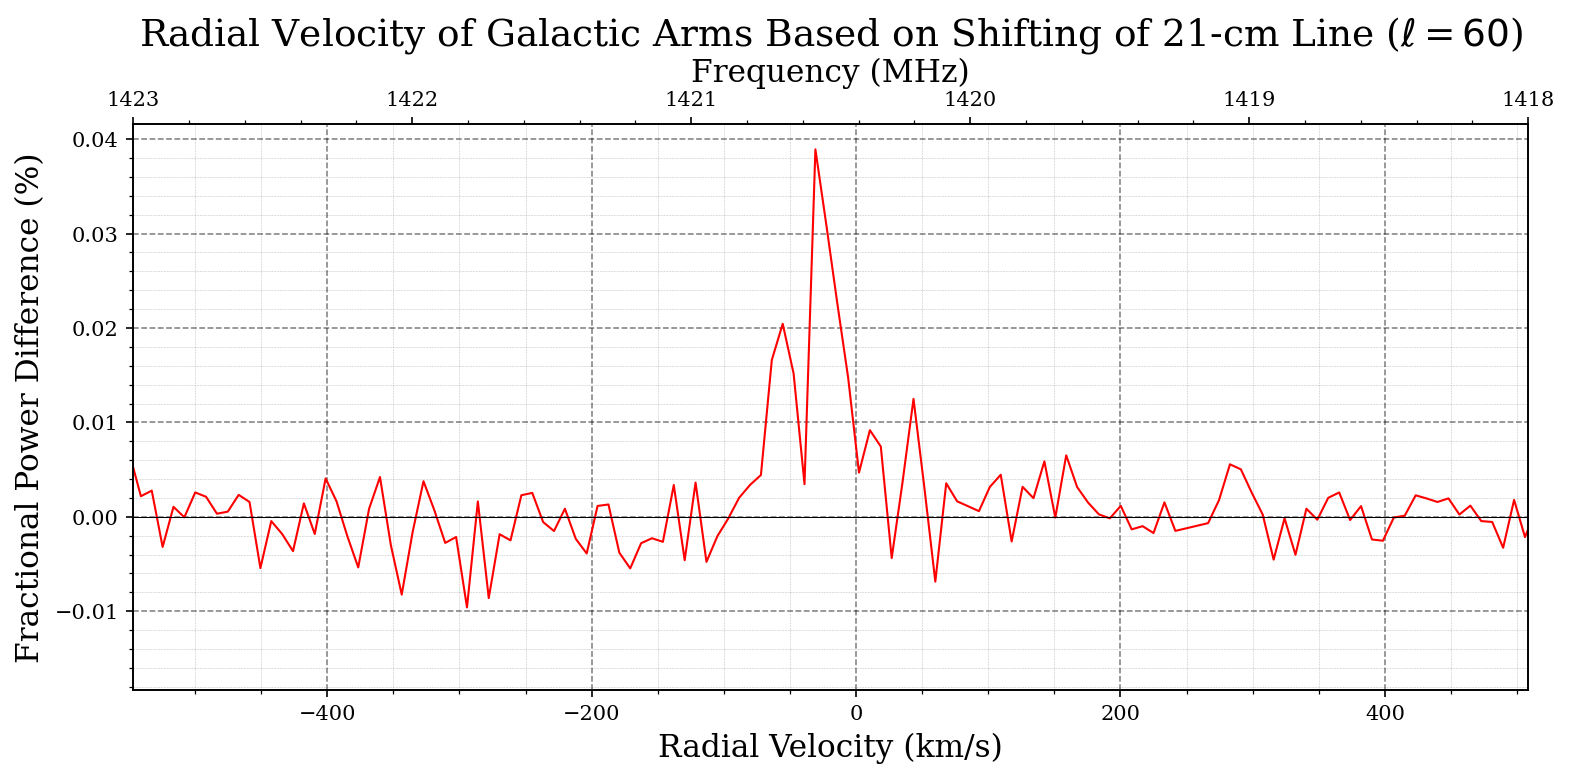

In [16]:
plot_functions.plot_normalized_signal(data[60], corrected_signal, 60, zoomed=True);

There are two obvious peaks in radial velocity, representing two arms of the galaxy moving at two separate velocities. We must calculate the tangential velocity and ring radius. 

Radius of the ring is found as $R = R_{\text{sun}}\cdot\sin{60^\circ} = 6.93 \text{ kpc}$

In [17]:
R_sun * np.sin(60 * np.pi/180) # Convert to radians

6.928203230275509

Tangential velocity is the radial velocity corresponding to the strongest signal. All significant peaks can be isolated, and the strongest one is selected.

In [18]:
def get_peak_rv_values(df, printout=False):
    # Convert frequency to radial velocity:
    radial_velocity = 2.99792e8 * (f21cm - df.freq)/df.freq
    signal = detrend(df)
    
    # Trim dataset to only look where -125km/s < RV < 0km/s
    limit = np.where(np.logical_and(radial_velocity>-100000, 
                                    radial_velocity<200000))[0]
    signal = signal.tolist()[limit[0]:limit[-1]]
    radial_velocity = radial_velocity.tolist()[limit[0]:limit[-1]]
    
    # Find peaks
    peaks = find_peaks(signal, height=0.0075)[0]
    if printout==True:
        for i in peaks:
            print('Signal %.3f: RV %.3f km/s' %(signal[i], radial_velocity[i]/1000))
    return [radial_velocity[i]/1000 for i in peaks]

# For longitude=60
get_peak_rv_values(data[60], printout=True);

Signal 0.034: RV 2.216 km/s
Signal 0.037: RV -14.273 km/s
Signal 0.010: RV -71.968 km/s


For the longitude $60^\circ$, the tangential velocity is $-14.27 \text{ km/s}$ (since it associates with the strongest signal) and the ring radius is $6.9 \text{ kpc}$. 

We also need to consider that the solar system is also moving through the galaxy, so the motion of our system needs to be added to the tangential velocity we found such that we can find a velocity relative to the galactic core. This is done with some more geometry:

$$ v = v_T + v_{\text{sun}}\cdot\sin{\ell} $$

where $v_{\text{sun}}$ is the speed of the sun around the Milky Way core, measured as 220 km/s. Applying this to the measurement taken at $\ell=60^\circ$, an orbital velocity of 227 km/s is determined.

In [19]:
v_sun + R_sun * np.sin(60 * np.pi/180)

226.9282032302755

Repeating these steps for each longitude, we can finally plot resulting orbital velocities of various rings that orbit the galactic core. Only galactic longitudes within the range of $0-90^\circ$ or $270-360^\circ$ will provide information on the Milky Way rotation curve. Longitudes between $90-270^\circ$ are directed away from the galactic core and the line-of-sight will never be tangent to any orbiting rings. Any measured radial velocities will never be in a direction equal to the direction of the line-of-sight. For this reason, we only consider data with longitudes in the range of $0-90^\circ$ for this analysis.

In [20]:
for l in longitudes[:16]:
    print('l = ' + str(l))
    get_peak_rv_values(data[l], printout=True)

l = 10
Signal 0.008: RV 117.686 km/s
Signal 0.030: RV -30.759 km/s
Signal 0.025: RV -47.244 km/s
l = 15
Signal 0.012: RV 43.445 km/s
Signal 0.009: RV 10.461 km/s
Signal 0.039: RV -30.759 km/s
Signal 0.020: RV -55.486 km/s
l = 20
Signal 0.009: RV 26.952 km/s
Signal 0.055: RV -22.516 km/s
Signal 0.026: RV -55.486 km/s
l = 25
Signal 0.008: RV 76.436 km/s
Signal 0.040: RV -22.516 km/s
Signal 0.016: RV -63.727 km/s
l = 30
Signal 0.008: RV 68.188 km/s
Signal 0.013: RV 43.445 km/s
Signal 0.016: RV 18.706 km/s
Signal 0.030: RV -14.273 km/s
Signal 0.012: RV -55.486 km/s
Signal 0.012: RV -80.208 km/s
l = 35
Signal 0.017: RV 43.445 km/s
Signal 0.018: RV 26.952 km/s
Signal 0.020: RV 10.461 km/s
Signal 0.032: RV -30.759 km/s
Signal 0.017: RV -80.208 km/s
l = 40
Signal 0.021: RV 43.445 km/s
Signal 0.037: RV 2.216 km/s
Signal 0.043: RV -30.759 km/s
Signal 0.021: RV -80.208 km/s
l = 45
Signal 0.008: RV 68.188 km/s
Signal 0.025: RV 35.198 km/s
Signal 0.049: RV -14.273 km/s
Signal 0.019: RV -71.968 km/s

In [21]:
# Strongest peaks in radial velocity:
peaks = [-30.759, -30.759, -22.516, -22.516, 43.445, 43.445, 43.445, 35.198, 
         10.461, 10.461, 2.216, -30.759, -22.516, -30.759, -22.516, -30.759]

We can finally plot resulting orbital velocities of various rings that orbit the galactic core. It is very obvious that this does not match the relationship modelled by the Keplerian rotation curve for the solar system, shown before. The data seems to increase until about 5 kpc, where it flattens off. 

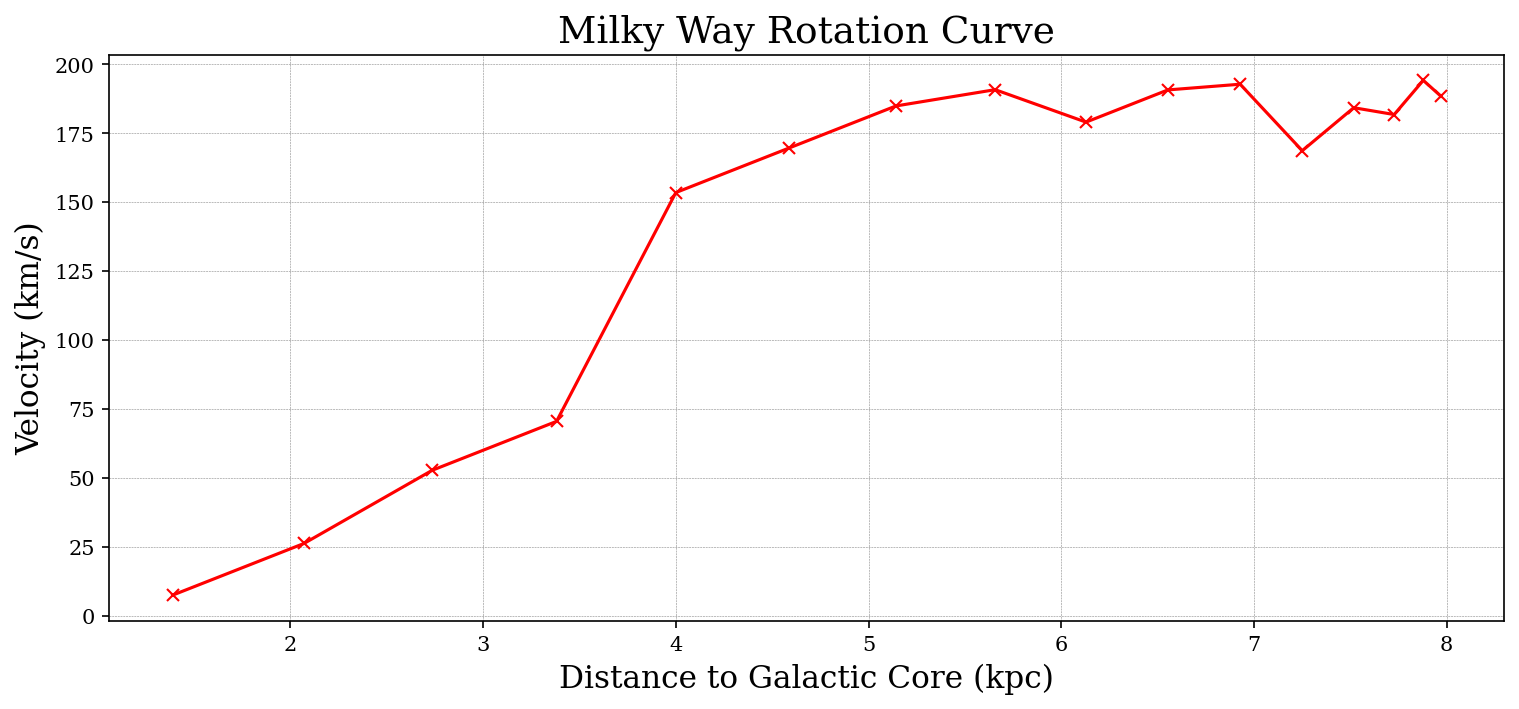

In [22]:
plot_functions.plot_rotation_curve(peaks, longitudes);

Overlaying this with the three rotation models illustrates the rotation curve best. It is clear the Milky Way fits to the **solid body rotation** best, up until the 5 kpc mark, where it then best fits a **differential rotation** model. 

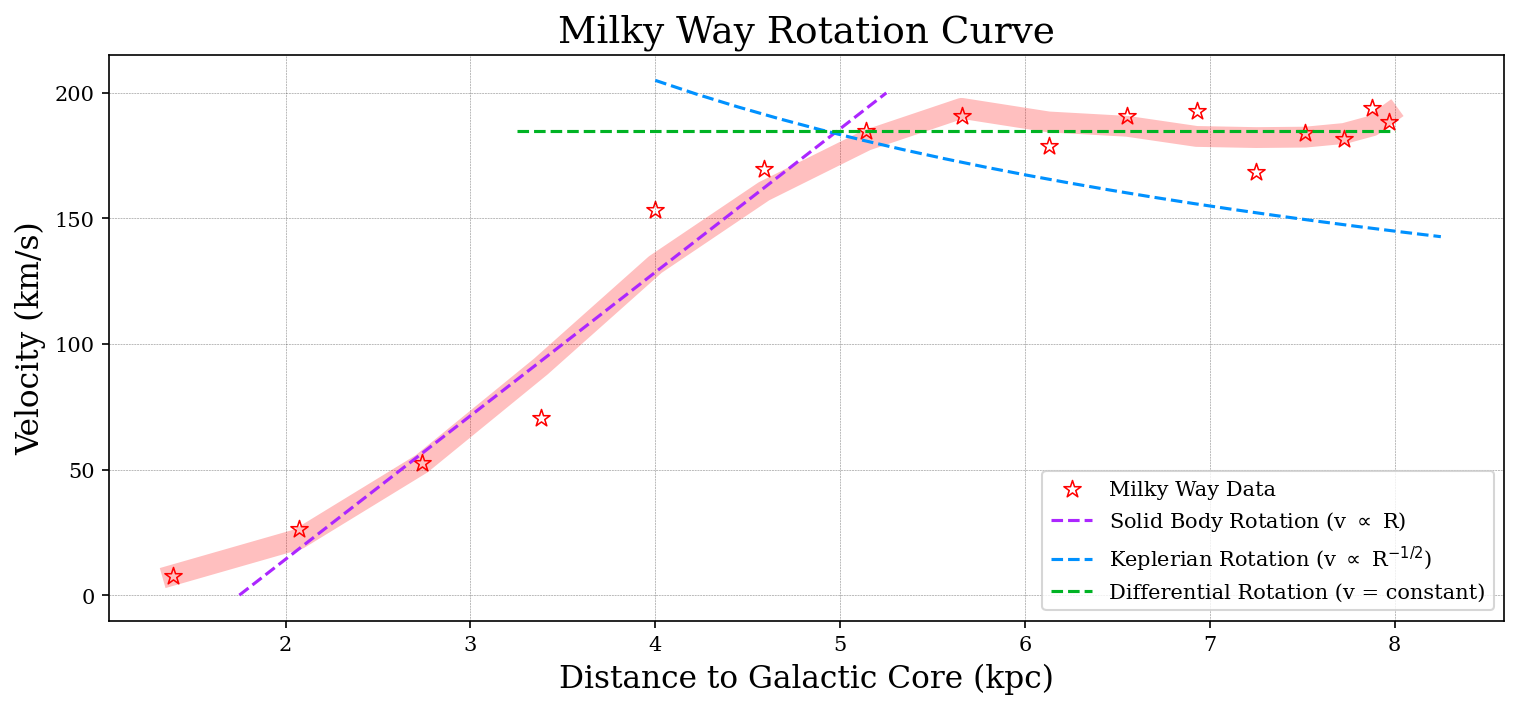

In [23]:
plot_functions.plot_rotation_curve(peaks, longitudes, comparison=True);

## What Does This Mean?

Based on what can be determined about the galaxy through measurements done using visible light, astronomers expected the rotation curve of the galaxy to increase linearly to about 5 kpc, then decrease following the proportionality of $v\propto R^{-1/2}$. This was found to be not the case. The plot above shows it does increase (almost) linearly up to 5 kpc, but does not decrease afterwards. This strongly implies the existence of dark matter in the galactic halo. In order for the rotation curve of the Milky Way to look the way is does, there must be a large quantity of mass distributed throughout the galaxy that is non-luminous or undetectable. Since it doesn't interact with EMR like normal matter, it misses being measured as part of the galaxy's mass, which is why the predicted curve was wrong. The measured galactic rotation curve acts as strong evidence towards the theory of dark matter.